## Classification with Audio

You were introduced to classification and clustering in the last section, and to STFT in the last lab.
All of these concepts will be used in this week's lab. 

This lab has two components: 
- Part 1: Audio-based classification for detecting voice (here)
- Part 2: Image segmentation based on pixel values and location (please see other ipynb)

### Necessary packages

- scipy
- matplotlib
- numpy
- IPython

If you are using Canopy or Anaconda, you wouldn't need any additional packages for this lab. If needed, you can install packages using `pip install` or `conda install` depending on your environment.



In [2]:
import numpy as np
import math
from __future__ import print_function
from matplotlib import pyplot as plt
from scipy.io import wavfile
from scipy.fftpack import dct
from IPython.display import Audio
from collections import defaultdict

%matplotlib inline

# Part 1: Mel Frequency Cepstral Coefficients 

You were introduced to the short time fourier transform in the last lab. The basic idea is to divide the audio into sections, apply appropriate windowing functions and then visualize the frequency content variation across time. In this week's lab we will use the MFCC coefficients:

The **Mel Frequency Cepstrum** is inspired by the human auditory response. It is observed that the human ear acts as a collection of filters, and concentrates only on certain frequency components. These filters are non-uniformly spaced on the frequency axis.

![](melfilterbank.jpg)

The *Mel Frequency Cepstrum* audio feature is being used succesfully in many audio processing applications. We will need some math tools from scipy to implement this audio feature extractor.

The Mel Frequency Cepstral Coefficients (MFCC) are computed as follows:

1. Compute the Fourier Transform of the (windowed) signal
2. Map power spectrum to the mel scale, using overlapping triangular windows (filter banks) as above. 
3. Take log of the power spectrum in the mel 'frequency' (one value corresponding to each mel filter)
4. Compute the Discrete Cosine Transform of the spectrum computed above, as though it were a signal

The amplitudes obtained are the MFCC. A block diagram of the process is shown here:
![](MFCC.png)

The reason for Step 4 above is because the filter bank coefficients computed in the previous step are highly correlated, which could be problematic in some machine learning algorithms. The application of transforms like the Discrete Cosine Transform (DCT) decorrelate the filter bank coefficients and yield a compressed representation of the filter banks. 

Typically, for Automatic Speech Recognition (ASR), the resulting cepstral coefficients 2-13 are retained and the rest are discarded; The reasons for discarding the other coefficients is that they represent fast changes in the filter bank coefficients and these fine details don’t contribute to Automatic Speech Recognition (ASR).

We implement each component below.

### Loading the wav data and hearing + visualizing the signal 

In [3]:
audio_file = 'data/italian.wav'
Fs, signal = wavfile.read(audio_file)

highfreq = Fs/2 # Nyquist rate
lowfreq = 0    

print('Low Frequency', lowfreq, 'High Frequency', highfreq)

Low Frequency 0 High Frequency 24000.0


In [4]:
Audio(audio_file)

In [5]:
print('Shape:', np.shape(signal))

Shape: (870240,)


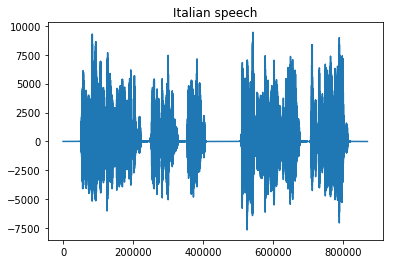

In [6]:
plt.figure()
plt.plot(signal)
plt.title('Italian speech')
plt.show()

## <span style="color:blue">Exercise 1:  </span>
Write a function to generate the power spectrum of a signal:

$$ P = \frac{|\mathcal{F}(x)|^2}{N} $$ where $N$ is the number of points in the Fourier transform $\mathcal{F}$. This will be used in the final exercises.

In [7]:
def get_power_spectrum(signal, NFFT):
    ''' Function to compute the power spectrum of a signal 
        using the formula above
        Args: 
            signal: [ndarray] audio signal
            NFFT: [int] number of points in the Fourier transform
        Returns:
            power: [ndarray] the corresponding power spectrum
        Hint:
            - You can use rfft from numpy.fft as in the last lab
    '''
    
    power =  np.absolute(np.fft.rfft(signal))**2
    power = np.divide(power, NFFT)
    
    return power

### Converting from frequency to mel frequency and vice versa

The formula to convert frequency $f$ Hertz to $m$ Mel is:

$$m = 2595 * log_{10}(1+\frac{f}{700})$$

## <span style="color:blue"> Exercise 2</span>

1. Derive the formula to convert from Mel back to Hertz
2. Implement these 2 conversions as functions

The formula to convert Mel back to Hertz is:

Your answer here: f = 700 * (10^(m/2595) - 1)

In [8]:
def hz2mel(freq):
    ''' This function should output the Mel frequencies given some input frequency
        h is a 1-d array of input frequencies in hertz
        Args:
            freq: [ndarray] frequencies in hertz
        Returns:
            mels: [ndarray] Mel scale frequncies based on above formula
    '''
    ## Your code here
    
    mels = np.multiply(np.log10(1 + (freq/700)), 2595)
    
    return mels

def mel2hz(mel):
    ''' This function should output the frequency in Hertz given some input quefrency
        m is a 1-d array of input quefencies in Mel
        Args:
            mels: [ndarray] Mel scale frequncies 
        Returns:
            freq: [ndarray] frequencies in hertz based on above formula          
    '''
    ## Your code here
    freq = np.multiply(700, 10 ** (mel / 2595) - 1)

    
    return freq

## Defining the Mel-spaced filter banks

The Mel-spaced filterbank is the set of triangular window filter which corresponds to human ear hearing perception.
![](melfilterbank.jpg)
The following code is to use to generate **num_filters** filters using the end points supplied by **bin_points** vector. You do not need to edit this part.

In [9]:
#filter bank generation
def filter_bank(num_filters, NFFT, bin_points):
    ''' Generate num_filters filters using the
        end points supplied by bin_points vector
        Args:
            num_filters: [int] number of Mel filters
            NFFT: [int] number of points in the FFT
            bin_points: end points of the Mel filters
        Returns:
            fbank: [ndarray] filter bank as visualized above
    '''
    fbank = np.zeros([num_filters,int(NFFT/2+1)])
    #print(fbank.shape)
    for j in range(0,num_filters):
        for i in range(int(bin_points[j]),int(bin_points[j+1])):
            #rising edge of the triangle
            #print(i)
            #print(j,"\n")
            fbank[j,i] = (i - bin_points[j])/(bin_points[j+1]-bin_points[j]) 
            
        for i in range(int(bin_points[j+1]),int(bin_points[j+2])):
            #falling edge of the triangle
            fbank[j,i] = (bin_points[j+2]-i)/(bin_points[j+2]-bin_points[j+1]) 
    return fbank

Let's now look at how the Mel-spaced filter banks are applied to the power spectrum of an audio signal. The following code generates the filter banks given the sampling frequency, number of filters, and length of the FFT.(You will need to finish the code for previous section for this part to run)

In [10]:
lowmel = hz2mel(lowfreq)     # convert to Mel scales
highmel = hz2mel(highfreq)

NFFT = 512            # number of FFT points
num_filters = 20           # number of Mel spaced filter banks

# convert the frequency into Mel points
mel_points = np.linspace(lowmel, highmel, num_filters + 2) # linear in Mel scale correspondings to human perception of sound
#print(mel_points)
bin_points = np.floor(mel2hz(mel_points)/Fs*(NFFT+1)) # convert back to Hert 
#print(bin_points)
fbank = filter_bank(num_filters, NFFT, bin_points)

Here's a visualization of the 20 filter banks in the frequency domain

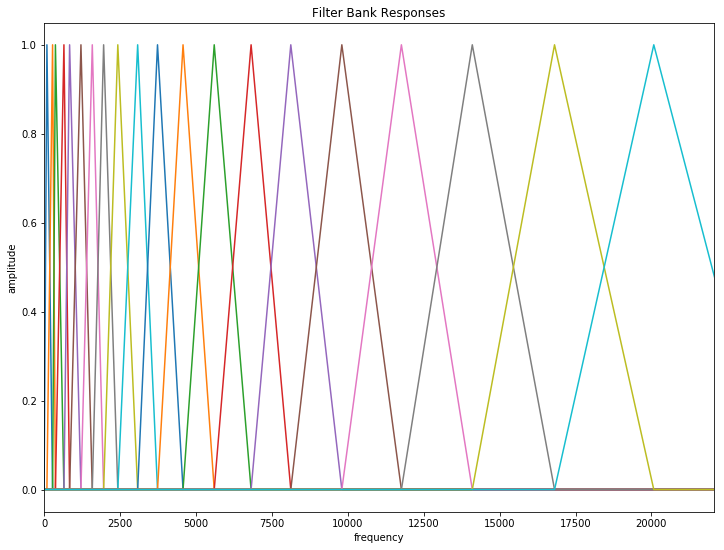

In [11]:
freq = np.arange(257)*(Fs/2.)/257    # generate frequencies for plot
plt.figure(figsize = (12, 9)) # make a bigger figure
for i in np.arange(num_filters):
    plt.plot(freq, fbank[i,:]) # plot 20 filter banks
plt.title('Filter Bank Responses')
ax = plt.axes()
ax.set_xlabel('frequency')
ax.set_ylabel('amplitude')
ax.set_xlim([0, 22050]);

In [12]:
print(bin_points)

[   0.    1.    3.    4.    7.    9.   13.   17.   21.   26.   33.   40.
   49.   60.   73.   87.  105.  126.  151.  180.  215.  256.]


### Question: looking at the filter bank, are human hearing sensitive to low or high frequencies?

Your answer here: Human ears are sensitive to low frequencies. There are more number of filters in the low frequency region compared to the high frequency region.

## <span style="color:blue"> Exercise 3</span>

Use the code from your previous lab to generate and plot a spectogram for the given wave segment `wav_segment`. The variable `data` should contain the spectrogram values. 

/Users/divyam/Library/Python/3.6/lib/python/site-packages/matplotlib/axes/_axes.py:7235: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


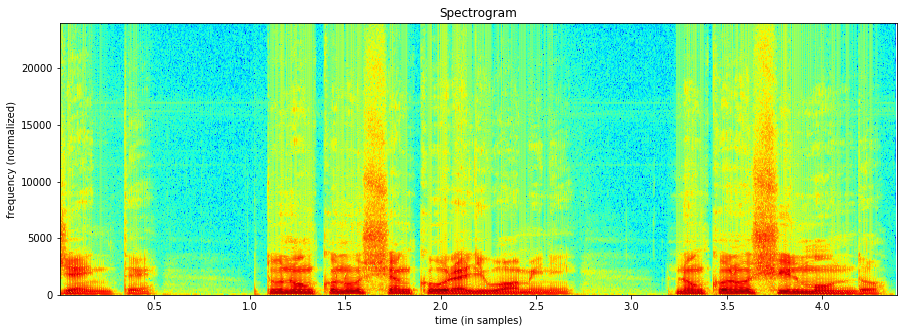

In [13]:
fig, (ax1) = plt.subplots(ncols=1) # create plot
fig.set_size_inches(15, 5)

N=512
M=128

wav_segment = signal[200000:411000]

# generate & plot spectrogram (built-in function)

# Your code here:
data, freqs, bins, im = ax1.specgram(wav_segment,Fs = Fs, NFFT=N, noverlap=(N-M), window = np.hamming(N), cmap = 'jet')   
ax1.axis('tight')
ax1.set_title('Spectrogram')
ax1.set_ylabel('frequency (normalized)')
ax1.set_xlabel('time (in samples)')

## <span style="color:blue"> Exercise 4</span>

To generate the MFCC, we first need to filter the frequency content through the Mel filter bank `fbank` we have created. 
To do so, use the `dot()` function from *numpy* to multiply the `fbank` and `data` and get the filter coefficients `mel_filtered`. Also, take the `log` of the filter coefficients and store in `log_filtered`.

In [14]:
mel_filtered = np.dot(fbank, data)
log_filtered = np.log(mel_filtered)
#log_filtered = np.reshape(log_filtered, [:,1])
#print(log_filtered.shape)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


We can visualize the filter bank coefficients `mel_filtered` using the code below:

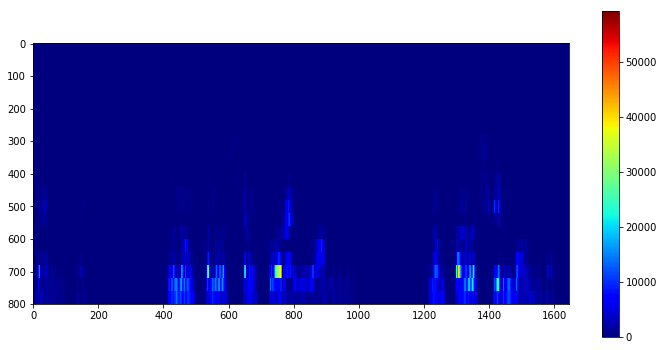

In [15]:
plt.figure(figsize=(12,6))
plt.imshow(np.repeat(mel_filtered[::-1, :], 40, axis=0), cmap='jet', interpolation='nearest')
plt.colorbar()
plt.show()

### Generating the MFCCs

The Mel Frequency Cepstral Coefficients (MFCCs) are the Discrete Cosine Transform **[DCT](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.fftpack.dct.html)** of the log coefficients `log_filtered`. 


We can visualize the MFCCs for a particular segment of the audio clip as below:

[ 8.21970905  5.60297122 -3.82027191  7.19639552  5.40015756  3.23282117
  1.04277397 -1.69037551 -2.01361644 -0.42843392  0.41095325 -0.78158092
  0.19108452  0.97694275  0.33229354 -0.41773403  0.03429493 -0.28186891
  0.24597804 -0.03644634]


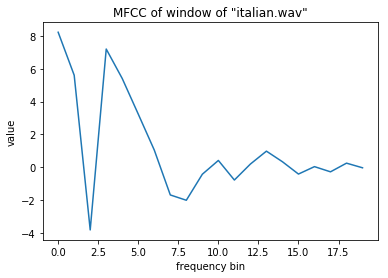

In [16]:
mfcc = dct(log_filtered[:, 5].T, type = 2, axis = 0, norm = 'ortho')# take the Discrete Cosine Transform

print(mfcc)

plt.figure()
plt.plot(mfcc)
plt.title('MFCC of window of "italian.wav"')
ax = plt.axes()
ax.set_xlabel('frequency bin')
ax.set_ylabel('value')

## <span style="color:blue"> Exercise 5</span>


With the information and code examples provided above, you should now be able to implement a function to compute the MFCC of a given signal. 

In [31]:
def calculate_MFCC(Fs, data, N, M):
    ''' Function to compute MFCC by dividing the signal into
        frames/sections of length N, and obtaining the MFCC of that frame.
        Args:
            Fs: [int] sampling frequency
            data: [array] signal to compute MFCC
            N: [int] length of section to use
            M: [int] amount of overlap in consecutive sections
        Returns:
            mfcc: [number_of_frames x num_Mel_filters] MFCC coefficients for each section
                  where you will compute number_of_frames such that each frame is of length N and
                  has consecutive frames have an overlap of M
                  and num_Mel_filters is the number of filters in the Mel filter bank
    '''
    
    #Your code here
    # 1. Compute number of frames/sections:
    # Hint: look at the file mfcclab.py to find the number of frames in a signal 
    
    numberOfFrames = int(math.ceil((data.shape[0] - N) / M) + 1)
    
    # 2. for each frame select the corresponding section of the data signal, i.e. from i*M to i*M + N for the i^th frame
    # - zero-pad the tail frames to be of size N
    # - compute the power spectrum using your function from Exercise 1
    # - dot product with the Mel filter bank
    # - take the log
    # - compute the DCT
    
    mfcc = np.empty([numberOfFrames, num_filters])
    index = 0
    
    for i in range(0, numberOfFrames):
        
        index = i * M
        if (i == (numberOfFrames - 1)):
            if ((data.shape[0] - index) != N):
                data_block_size = data.shape[0] - index
                data_each_frame = data[index:(index + data_block_size)]
                data_each_frame = np.append(data_each_frame, np.zeros(N - data_block_size))
            else:
                data_each_frame = data[index:(index + N)]
        else:
            data_each_frame = data[index:(index + N)]
        
        data_each_frame = np.array(data_each_frame)
        power_spectrum = get_power_spectrum(data_each_frame, data_each_frame.shape[0])
        mel_filter = np.dot(fbank, power_spectrum)
        log_filter = np.log(mel_filter)
        mfcc[i] = dct(log_filter.T, type = 2, axis = 0, norm = 'ortho')
        
    mfcc = np.array(mfcc)
    print(mfcc.shape)
    return mfcc    

# Speaker Identification

In this exercise, we will utilize the MFCC feature to recognize the identity of a speaker. You should put the two folders that were provided, train and test, into the same folder of your ipython notebook. There are 8 training data files and 8 testing data files, s1.wav to s8.wav. The training and testing data are already correctly labeled, i.e, s1.wav in the training folder matches with s1.wav in the testing folder (same person speaking). Nearest neighbor will be used to label the testing data.

Each audio file in this dataset is mono-channel. However the files are of different length, which requires special attention to allocate the training dataset. For each audio file in the train folder, we create its MFCC matrix, where each row corresponds to 12 MFCC's of one frame. If your signal has 125 frames, for instance, the size of MFCC matrix will be 125 by 12. The MFCC matrix of all audio files are stacked into one matrix called the **codebook**. At the same time, we also store the labels of the training data. 

## Training

We first calculate the total number of frames of our whole dataset. This is used to initialize the codebook matrix and the label vector. Let's say you have only 2 audio files. The first file has 10 frames, and the second has 20 frames. Then the size of your **codebook** is 30 by 12. 

The length of your **labels** vector will be 30, in which the first 10 elements are *1* and the last 20 elements are *2*. For this exercise, we will choose the length of each frame to be 512 and the step size is one third of the frame length.

In [18]:
import mfcclab
N = 512
M = int(512/3)
print(N, M)
sumNumFrames = mfcclab.get_num_frames("train", N, M) # total number of frames for all of the training data. 

512 170


We define the range of frequencies for our filter banks in Hertz, *lowfreq* and *highfreq* (from 0 Hz to the Nyquist rate). To create the endpoints for our filter banks, we transform this range into mel-scale range. The *for* loop loads all the training data in the **train** folder, computes the MFCC's, and appends them to the **codebook**. Since we know the labels of our data, this is considered an example of *supervised learning*, as opposed to an *unsupervised learning* paradigm, like K-means clustering, where the labels are unknown and must be learned.

In [32]:
highfreq = Fs/2 # Nyquist rate
lowfreq = 0 # lower end of audio spectrum

lowmel = hz2mel(lowfreq) # convert to Mel scales
highmel = hz2mel(highfreq)

NFFT = 512 # number of FFT points

nfilt = 20 # number of Mel spaced filter banks

# convert the frequency into Mel points
melPoints = np.linspace(lowmel, highmel, nfilt + 2)
binPoints = np.floor(mel2hz(melPoints)/Fs*(NFFT+1))

numKeptCoeff = 12 # we only keep the lower 12 coefficients since the higher frequencies 
# do not help speaker identification. we also ignore index 0 since this corresponds to the 
# volume level / DC value

fbank = filter_bank(nfilt, NFFT, binPoints) # create the Mel-spaced filter bank
codeBook = np.empty((sumNumFrames, numKeptCoeff-1)) #preallocate the training data
labels = np.zeros((sumNumFrames,)) # and the labels

currentIdx = 0
for i in range(1,9): # we have 8 signals
    filename = "train/s%d.wav" % i # this is how you replace %d with i in Python 2. 
    fs, data = wavfile.read(filename)
    mfcc = calculate_MFCC(fs, data, N, M)[:,1:numKeptCoeff]
    print(mfcc.shape)
    codeBook[currentIdx:currentIdx + mfcc.shape[0],:] = mfcc# assign this training data to codebook
    labels[currentIdx:currentIdx + mfcc.shape[0]] = i # and label them
    currentIdx = currentIdx + mfcc.shape[0] # move to next block in codeBook and labels
print(codeBook.shape)    

(75, 20)
(75, 11)
(78, 20)
(78, 11)
(77, 20)
(77, 11)
(86, 20)
(86, 11)
(105, 20)
(105, 11)
(86, 20)
(86, 11)
(83, 20)
(83, 11)
(84, 20)
(84, 11)
(674, 11)


Since the each codeword in the codebook is of dimension 11, it is not possible to visualize the distribution of the codewords and their proximity to each other. However, tools exist that attempt to reduce the dimensionality of data while preserving the relative distances between data points. The following code uses a tool called Isomap (a non-linear dimension-reduction technique, unlike PCA) to plot the data in 2D to give some intuition of the distribution of the codewords. 

### Question: How well grouped are the codewords for each speaker?

Your answer here: It is difficult to say how well the codewords are grouped because we are plotting codewords of dimension 11 on a 2D scatter plot. By seeing relative distances, we can see that speaker 1 is well-grouped, whereas speakr 6 seems to be scattered everywhere.


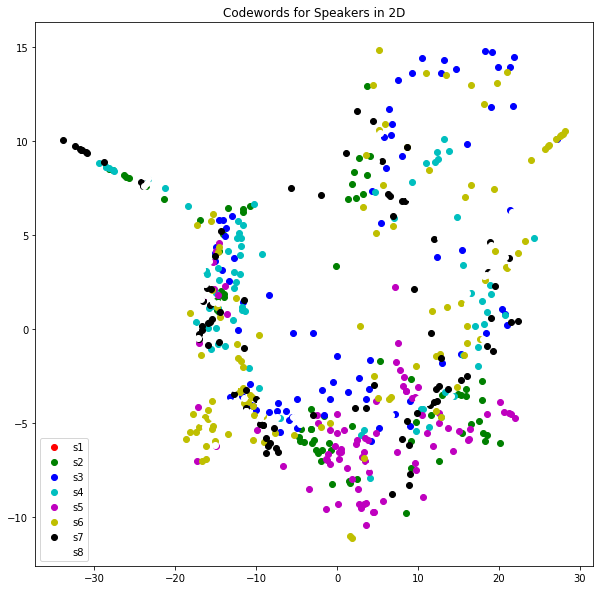

In [20]:
#mfcclab.plot_codebook_2D(codeBook, labels, ["s2", "s4"])
mfcclab.plot_codebook_2D(codeBook, labels, ["s1", "s2", "s3", "s4", "s5", "s6", "s7", "s8"])

## <span style="color:blue"> Exercise 6</span>


1. Use your favourite classifier from part I of the course to train on the given data based on the MFCCs for each frame using the data in the `train` folder

In [21]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

classifier = LinearDiscriminantAnalysis()
classifier.fit(codeBook, labels) 

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)

2. Load a test file

In [22]:
filename = "test/s3.wav" #try load one testing wave file
fs, data = wavfile.read(filename)
mfcc = calculate_MFCC(fs, data, N, M)

We will now predict the label of each frame you just computed. There will be some mislabeled data. 

In [23]:
pred_label = np.round(classifier.predict(mfcc[:,1:numKeptCoeff]))
print(pred_label)

[ 1.  5.  5.  7.  5.  5.  1.  1.  2.  5.  5.  2.  2.  2.  5.  5.  1.  1.
  1.  5.  5.  1.  1.  2.  2.  1.  1.  1.  1.  6.  6.  6.  6.  5.  5.  5.
  2.  2.  2.  2.  2.  2.  8.  3.  3.  1.  3.  3.  2.  6.  6.  6.  6.  6.
  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  3.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  6.  6.  6.  6.  6.  7.  7.  7.  7.  7.  5.  7.  1.
  7.  5.  5.  7.  7.  7.  5.  7.  5.  7.  7.  7.  7.  1.  8.  1.  2.  2.
  1.  2.]


In [24]:
 # this is used to find the most occured label
d = defaultdict(int)
for i in pred_label:
    d[i] += 1
result = max(d.items(), key=lambda x: x[1])
print("Matching speaker:", result) #the first result is the label,
# the second is the number of occurences

Matching speaker: (6.0, 27)


3. Try different speakers for testing above. 
    - Is any speaker wrongly classified? 
    - Which speaker has the lowest number of votes but is correctly classified?
    - How can this classification task be improved?

Speaker 1 Result: Matching speaker: (1.0, 15)
Speaker 2 Result: Matching speaker: (2.0, 29)
Speaker 3 Result: Matching speaker: (6.0, 27)
Speaker 4 Result: Matching speaker: (4.0, 52)
Speaker 5 Result: Matching speaker: (5.0, 25)
Speaker 6 Result: Matching speaker: (6.0, 50)
Speaker 7 Result: Matching speaker: (7.0, 21)
Speaker 8 Result: Matching speaker: (6.0, 36)
        
Speaker 3, 8 are wrongly classified. 

Speaker 1 is correctly classified with the least number of votes.

The classification task could be improved by using another classifier more suitable for this purpose. 
I would try all the classifiers I know to minimise wrong classifications. 
